In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import MolsToGridImage

#Show mols in dataframes

from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

from pathlib import Path

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data'/'raw'
interim_dir = Path(TOP) / 'data'/'interim'
external_dir = Path(TOP) / 'data'/'external'
figures_dir = Path(TOP) / 'reports'/'figures/'


In [3]:
df = pd.read_excel(raw_dir/'ICF_extractions_160125.xlsx', index_col = [0])

In [4]:
df.groupby('Index').size()

Index
1      12
2       4
3      17
4      14
5      20
       ..
153     6
154     5
155     3
156     2
157    15
Length: 157, dtype: int64

June-Feb 2024 extraction set has extracted 157 read-across examples

In [5]:
df.shape

(1019, 52)

In [6]:
df.Index.nunique()

157

In [7]:
df.columns

Index(['Index', 'Substance Name in Assessment',
       'Substance Number in Assessment', 'Substance Role',
       'Read-Across Assessment Title', 'Year of Assessment',
       'Link to Assessment',
       'Source (e.g. OECD IATA case study,  U.S. EPA PPRTV, journal article, primary author, etc.)',
       'Decision Context Purpose (e.g., regulatory, hazard screening, risk assessment, REACH, TSCA, test order, framework validation, etc.)',
       'Approach \n(Analogue or Category)', 'DTXSID', 'Preferred Name',
       'CASRN', 'IUPAC_NAME', 'SMILES', 'QSAR Ready SMILES',
       'Analogue Role (specific for PPRTV assessments)',
       'Critical Effect(s) (short-term or longer exposure)',
       'Route of Exposure', 'Study Type', 'Study Duration',
       'Study Duration Units', 'Species', 'LOAEL/LOAEC', 'LOAEL/LOAEC units',
       'LOEL/LOEC', 'LOEL/LOEC units', 'NOAEL/NOAEC', 'NOAEL/NOAEC units',
       'NOEL/NOEC', 'NOEL/NOEC units', 'Reference for Toxicity Study ',
       'POD Method', 'PO

In [8]:
df = (df
 .rename(columns = {'Decision Context Purpose (e.g., regulatory, hazard screening, risk assessment, REACH, TSCA, test order, framework validation, etc.)': 'decision_context', 'Approach \n(Analogue or Category)': 'Approach', 'Source (e.g. OECD IATA case study,  U.S. EPA PPRTV, journal article, primary author, etc.)': 'Source', 'Analogue Evidence Stream': 'analogue_evidence_stream', 'DTXSID':'dtxsid', 'Substance Role': 'substance_role'})
)

In [9]:
df['decision_context'].unique()

array(['Case study to clarify regulatory acceptance and improve OECD guidance',
       'Read-across framework validation for risk assessment',
       'Case study to demonstrate read-across attempted for registration under EU REACH and accepted under OECD HPV programme',
       'Case study to illustrate issues with read-across and improve OECD guidance',
       'Case study to suggest key elements for read-across that may be used for regulatory purposes',
       'Case study for risk assessment with strategy designed to pass the ECHA RAAF',
       'Case study to illustrate issues with read-across and help develop OECD guidance',
       'Risk assessment',
       'Case study of hazard characterization for screening assessment under the Japanese Chemical Substances of Control Law (CSCL)',
       'Screening assessment under Japanese Chemicals Substances Control Law (CSCL)',
       'REACH registration',
       'Case study to illustrate issues associated with predicting subchronic effects (not 

In [10]:
decision_context = {'Case study to clarify regulatory acceptance and improve OECD guidance' : 'technical_guidance',
       'Read-across framework validation for risk assessment' : 'technical_guidance',
       'Case study to demonstrate read-across attempted for registration under EU REACH and accepted under OECD HPV programme' : 'regulatory_purpose',
       'Case study to illustrate issues with read-across and improve OECD guidance' : 'technical_guidance',
       'Case study to suggest key elements for read-across that may be used for regulatory purposes' :'technical_guidance',
       'Case study for risk assessment with strategy designed to pass the ECHA RAAF':'technical_guidance',
       'Case study to illustrate issues with read-across and help develop OECD guidance':'technical_guidance',
       'Risk assessment':'regulatory_purpose',
                     'Case study for risk assessment': 'regulatory_purpose',
       'Case study of hazard characterization for screening assessment under the Japanese Chemical Substances of Control Law (CSCL)':'regulatory_purpose',
       'Screening assessment under Japanese Chemicals Substances Control Law (CSCL)':'regulatory_purpose',
       'REACH registration':'regulatory_purpose',
       'Case study to illustrate issues associated with predicting subchronic effects (not intended for any regulatory purposes)':'technical_guidance',
       'Case study to demonstrate how NAMs can support read-across for REACH registration' : 'NAMs',
       'Case study to demonstrate application of an AOP-based testing strategy for read across (under the domain of the EFSA)' : 'NAMs',
       "Hazard characterization; Groupings Initiative of Canada's Chemical's Management Plan (CMP)":'regulatory_purpose',
       'Case study to demonstrate how NAMs can support read-across': 'NAMs',
       'Calculate permitted daily exposure under the European Medicine Agency (EMA) guideline':'regulatory_purpose',
       'Case study to improve guidance for read-across':'technical_guidance',
       'Case study to demonstrate how metabolomics data can be used to improve chemical grouping for read-across predictions; to compare the predicted outcome with actual study outcome required by REACH' :'NAMs',
       'Case study to demonstrate how metabolomics data can be used to support read-across predictions for REACH registration' : 'NAMs',
       'Hazard assessment; OECD HPV Programme':'regulatory_purpose',
       "Screening risk assessment/risk characterization; Canada's Chemical's Management Plan (CMP)": 'regulatory_purpose', 'Safety assessment': 'safety_assessment'}

In [11]:
len(decision_context)

24

In [12]:
df = (df
 .assign(use_case = lambda df: df['decision_context'].replace(decision_context))
)

There are 24 unique decisions context which when aggregated by NAMs, technical guidance or regulatory purposes finds of the 157 examples, 71 capture regulatory purposes, 68 for safety assessments with the remainder are relatively evenly split between efforts to improve guidance or evaluate the utility of NAMs to substance read-across.

In [13]:
dtxsid_multiple = df.groupby('dtxsid')['Index'].nunique().loc[lambda x:x>1].index

#dtxsid_multiple = df.groupby('dtxsid')['Index'].nunique().loc[lambda x: x > 1].index

In [14]:
df[df['dtxsid'].isin(dtxsid_multiple)][['dtxsid', 'Index']].to_csv(interim_dir/'duplicative_chems_studies.csv')

In [15]:
df[(df['Index'] == 3) & (df['dtxsid'] == 'DTXSID8024284')][['Critical Effect(s) (short-term or longer exposure)',
       'Route of Exposure', 'Study Type', 'Study Duration',
       'Study Duration Units', 'Species', 'LOAEL/LOAEC', 'LOAEL/LOAEC units',
       'LOEL/LOEC', 'LOEL/LOEC units', 'NOAEL/NOAEC', 'NOAEL/NOAEC units',
       'NOEL/NOEC', 'NOEL/NOEC units', 'Reference for Toxicity Study ',
       'POD Method', 'POD', 'POD units', ]]

,Critical Effect(s) (short-term or longer exposure),Route of Exposure,Study Type,Study Duration,Study Duration Units,Species,LOAEL/LOAEC,LOAEL/LOAEC units,LOEL/LOEC,LOEL/LOEC units,NOAEL/NOAEC,NOAEL/NOAEC units,NOEL/NOEC,NOEL/NOEC units,Reference for Toxicity Study,POD Method,POD,POD units
Status,,,,,,,,,,,,,,,,,,
QC done,maternal toxicity (central nervous system effe...,inhalation,developmental,NaN,NaN,rat,NaN,NaN,NaN,NaN,1500,ppm,NaN,NaN,"Hanley, T.R. et al., 1984. Teratologic evaluat...",NaN,NaN,NaN
QC done,maternal toxicity; no developmental effects ob...,inhalation,developmental,NaN,NaN,rabbit,NaN,NaN,NaN,NaN,1500,ppm,NaN,NaN,"Hanley, T.R. et al., 1984. Teratologic evaluat...",NaN,NaN,NaN
QC done,parental toxicity,inhalation,"reproductive, 2-generation",NaN,NaN,rat,NaN,NaN,NaN,NaN,300,ppm,NaN,NaN,NaN,NaN,NaN,NaN
QC done,not specified,dermal,subchronic,90,day,rabbit,NaN,NaN,NaN,NaN,1838,mg/kg,NaN,NaN,Not reported,NaN,NaN,NaN
QC done,not specified,inhalation,subchronic,90,day,rat,NaN,NaN,NaN,NaN,1000,ppm,NaN,NaN,Not reported,NaN,NaN,NaN
QC done,not specified,inhalation,subchronic,90,day,rabbit,NaN,NaN,NaN,NaN,1000,ppm,NaN,NaN,Not reported,NaN,NaN,NaN


In [16]:
#df.decision_context.value_counts().plot.barh()

In [17]:
df.drop_duplicates(subset=['Index', 'use_case'])['use_case'].value_counts(dropna = False, normalize = True)

use_case
regulatory_purpose    0.452229
safety_assessment     0.433121
NAMs                  0.063694
technical_guidance    0.050955
Name: proportion, dtype: float64

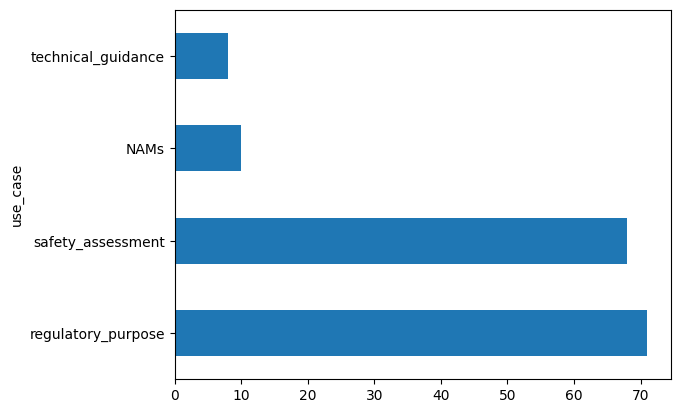

In [18]:
df.drop_duplicates(subset=['Index', 'use_case'])['use_case'].value_counts(dropna = False).plot.barh();


In [19]:
source_dict = {k: v for k,v in zip(df['Source'].unique(),df['Source'].unique())}

In [20]:
#source_dict

In [21]:
source_dict = {'OECD IATA case study': 'OECD IATA case study',
 'Journal article': 'journal_article',
 'OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2017.02.005)': 'OECD IATA case study',
 'OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2018.05.001)': 'OECD IATA case study',
 'OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2017.02.002)': 'OECD IATA case study',
 'US EPA PPRTV': 'US EPA PPRTV',
 'OECD IATA case study; Journal article (https://doi.org/10.1016/j.yrtph.2014.10.011)': 'OECD IATA case study',
 'OECD IATA case study (developed by EU ToxRisk project [BIAC])': 'OECD IATA case study',
 'OECD SIDS': 'OECD SIDS',
 'Health Canada screening assessment for the Challenge': 'Health Canada case study',
 'ECETOC case study': 'ECETOC case study',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.112897)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2015.09.006)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2016.07.028)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113125)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2015.09.014)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2015.12.014)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2015.12.015)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2016.04.002)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2016.07.029)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113031)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2016.09.022)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113265)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2016.09.023)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113459)': 'journal_article',
 'RIFM; Journal article (http://dx.doi.org/10.1016/j.fct.2016.10.029)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2019.110716)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2019.111002)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113117)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111338)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111337)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111465)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111456)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111470)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111640)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111696)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111730)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111735)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111759)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111871)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2020.111868)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2021.111989)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2021.112174)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2021.112181)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2021.112360)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2021.112458)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2021.112453)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2021.112711)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.112870)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.112876)': 'journal_article',
 'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113408)': 'journal_article',
 'Journal article (https://doi.org/10.3109/10408444.2011.623149)': 'journal_article',
 'Journal article (http://dx.doi.org/10.1016/j.yrtph.2012.02.006)': 'journal_article',
 'Journal article (https://doi.org/10.1080/10408440600894914)': 'journal_article',
 'Journal article (10.1016/j.yrtph.2009.09.006 )': 'journal_article',
 'Journal article (doi: 10.1016/j.yrtph.2011.03.002)': 'journal_article',
 'Journal article (10.2131/jts.37.503)': 'journal_article',
 'Journal article (10.3109/10408444.2013.792328)': 'journal_article',
 'Journal article (10.1007/s00204-016-1752-5)': 'journal_article',
 'Journal article (10.1016/j.fct.2018.06.028)': 'journal_article',
 'Journal article (10.1080/01480545.2019.1650061)': 'journal_article',
 'Journal article (10.1016/j.yrtph.2022.105161)': 'journal_article',
 'Journal article (10.1093/toxsci/kfac139 )': 'journal_article',
 'Journal article (10.1016/j.yrtph.2022.105181)': 'journal_article',
 'Journal article (10.1016/j.yrtph.2020.104855)': 'journal_article'}

In [22]:
df =(df
 .assign(source = lambda df: df['Source'].replace(source_dict))
)

<Axes: ylabel='source'>

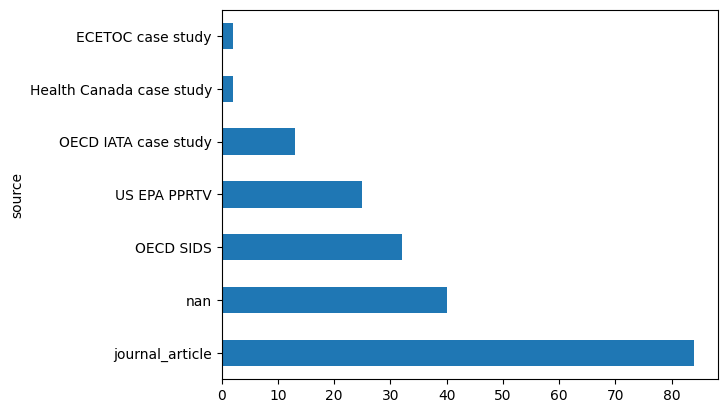

In [23]:
df.drop_duplicates(subset=['Index', 'source'])['source'].value_counts(dropna = False).plot.barh()

In [24]:
df.drop_duplicates(subset=['Index', 'source'])['source'].value_counts(dropna = False, normalize = True)

source
journal_article             0.424242
NaN                         0.202020
OECD SIDS                   0.161616
US EPA PPRTV                0.126263
OECD IATA case study        0.065657
Health Canada case study    0.010101
ECETOC case study           0.010101
Name: proportion, dtype: float64

In [25]:
df.drop_duplicates(subset=['Index', 'source'])['source'].value_counts(dropna = False)

source
journal_article             84
NaN                         40
OECD SIDS                   32
US EPA PPRTV                25
OECD IATA case study        13
Health Canada case study     2
ECETOC case study            2
Name: count, dtype: int64

In [26]:
#df['Approach \n(Analogue or Category)']
df.drop_duplicates(subset=['Index', 'Approach'])['Approach'].value_counts(dropna = False, normalize = True)

Approach
Analogue             0.573248
Category             0.388535
Category/Analogue    0.038217
Name: proportion, dtype: float64

In [27]:
#df.groupby(['source'])['Approach'].value_counts(normalize = True).reset_index()

|Source  | Approach | Proportion of cases|
|:-:|:-:|:-:|
|ECETOC case study |       Category |                            1.000000|
|Health Canada case study | Analogue   |                          1.000000|
|Journal article       |    Category     |                        0.629870|
 |                         |Analogue                    |         0.37|
|OECD IATA case study|      Category      |                       0.989418|
 |                         |Analogue                         |    0.010582|
|OECD SIDS  |               Category         |                    0.836538|
  |                      |  Category/Analogue       |            0.163462|
|US EPA PPRTV      |        Analogue          |                   1.000000|

If we look at the approaches with respect to the source - all of the EPA PPRTV cases rely on an analogue approaches, whereas in general over 80% of all the OECD IATA case studies, SIDS dossiers relied on a category approach. Journal articles favoured a category approach (63%) but there was a reasonable proportion of analogue cases (37%).

In [28]:
df.dtxsid.nunique()

695

In [29]:
df.SMILES.nunique()

661

In [30]:
df[df['SMILES'].isnull()]['Index'].nunique()

15

In [31]:
(df['Year of Assessment'].value_counts())

Year of Assessment
2012.0    120
2017.0    116
2020.0     96
2011.0     79
2016.0     79
2014.0     66
2021.0     57
2010.0     52
2013.0     50
2006.0     49
2009.0     47
2018.0     46
2019.0     21
2022.0     18
2015.0     15
2004.0     11
2008.0      9
2005.0      5
2023.0      3
Name: count, dtype: int64

In [42]:
df.columns

Index(['Index', 'Substance Name in Assessment',
       'Substance Number in Assessment', 'substance_role',
       'Read-Across Assessment Title', 'Year of Assessment',
       'Link to Assessment', 'Source', 'decision_context', 'Approach',
       'dtxsid', 'Preferred Name', 'CASRN', 'IUPAC_NAME', 'SMILES',
       'QSAR Ready SMILES', 'Analogue Role (specific for PPRTV assessments)',
       'Critical Effect(s) (short-term or longer exposure)',
       'Route of Exposure', 'Study Type', 'Study Duration',
       'Study Duration Units', 'Species', 'LOAEL/LOAEC', 'LOAEL/LOAEC units',
       'LOEL/LOEC', 'LOEL/LOEC units', 'NOAEL/NOAEC', 'NOAEL/NOAEC units',
       'NOEL/NOEC', 'NOEL/NOEC units', 'Reference for Toxicity Study ',
       'POD Method', 'POD', 'POD units', 'RfC/p-RfC Toxicity Type',
       'RfC/p-RfC Value', 'RfC/p-RfC units', 'RfD/p-RfD Toxicity Type',
       'RfD/p-RfD Value', 'RfD/p-RfD units', 'Other Toxicity Value Type',
       'Other Toxicity Value', 'Other Toxicity Value un

In [43]:
df2 = (df
       .assign(
        year_of_assessment=lambda df: pd.to_datetime(
            df["Year of Assessment"],  # Only convert non-missing values
            format='%Y',
            errors='coerce'  # Coerce invalid conversions to NaT
        ))
  .filter(['Index','Year of Assessment', 'year_of_assessment','Read-Across Assessment Title', 'Year of Assessment',
       'Link to Assessment', 'Source', 'decision_context', 'Approach',
       'dtxsid', 'Preferred Name', ])
      )


In [50]:
#df2[df2['year_of_assessment'] =='2011-01-01']

In [57]:
(df2
 .query("year_of_assessment.dt.year  == 2022")
 .Source.unique()
)

array(['RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.112897)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113125)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113031)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113265)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113459)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113117)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2021.112711)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.112870)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.112876)',
       'RIFM; Journal article (https://doi.org/10.1016/j.fct.2022.113408)',
       'Journal article (10.1016/j.yrtph.2022.105161)',
       'Journal article (10.1016/j.yrtph.2022.105181)'], dtype=object)

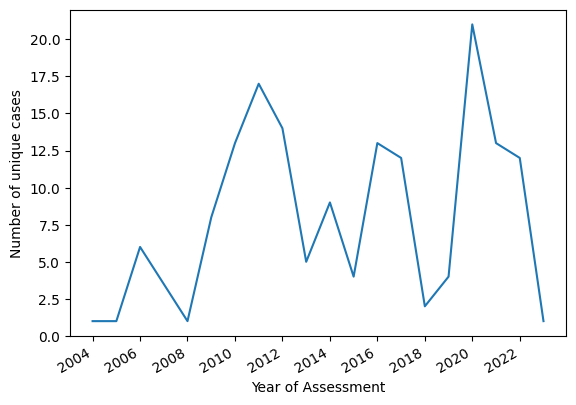

In [40]:
#| label: fig-year
#| fig-cap: "Number of unique cases per year"

df2.groupby("year_of_assessment")["Index"].nunique().plot(kind ='line')
plt.xlabel('Year of Assessment')
plt.ylabel('Number of unique cases');

In [41]:
df2groupby("year_of_assessment")["Index"].nunique()

year_of_assessment
2004-01-01     1
2005-01-01     1
2006-01-01     6
2008-01-01     1
2009-01-01     8
2010-01-01    13
2011-01-01    17
2012-01-01    14
2013-01-01     5
2014-01-01     9
2015-01-01     4
2016-01-01    13
2017-01-01    12
2018-01-01     2
2019-01-01     4
2020-01-01    21
2021-01-01    13
2022-01-01    12
2023-01-01     1
Name: Index, dtype: int64

In [82]:
#df[df['SMILES'].isnull()].head()#["Source (e.g. OECD IATA case study,  U.S. EPA PPRTV, journal article, primary author, etc.)"].unique()

In [40]:
#df[df['SMILES'].isnull()]

In [61]:
df1 = (
    df.reset_index()
      .groupby('Index', group_keys=False)
      .apply(lambda group: group.drop_duplicates(subset=['dtxsid']),include_groups=False)
      .filter(['Index',
               'Substance Name in Assessment',
               'substance_role',
               'Approach',
               'dtxsid',
               'Preferred Name',
               'CASRN',
               'SMILES',
               'QSAR Ready SMILES',
               'analogue_evidence_stream',
               'use_case',
               'source'])
)

In [97]:
df1

,Substance Name in Assessment,substance_role,Approach,dtxsid,Preferred Name,CASRN,SMILES,QSAR Ready SMILES,analogue_evidence_stream,use_case,source
0,Chlorobenzene,Target,Category,DTXSID4020298,Chlorobenzene,108-90-7,ClC1=CC=CC=C1,ClC1=CC=CC=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
1,"1,4-Dichlorobenzene",Target,Category,DTXSID1020431,"1,4-Dichlorobenzene",106-46-7,ClC1=CC=C(Cl)C=C1,ClC1=CC=C(Cl)C=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
2,"1,2-Dichlorobenzene",Category member,Category,DTXSID6020430,"1,2-Dichlorobenzene",95-50-1,ClC1=C(Cl)C=CC=C1,ClC1=C(Cl)C=CC=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
3,"1,3-Dichlorobenzene",Target,Category,DTXSID6022056,"1,3-Dichlorobenzene",541-73-1,ClC1=CC(Cl)=CC=C1,ClC1=CC(Cl)=CC=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
4,"1,2,4-Trichlorobenzene",Source Analogue,Category,DTXSID0021965,"1,2,4-Trichlorobenzene",120-82-1,ClC1=CC(Cl)=C(Cl)C=C1,ClC1=CC(Cl)=C(Cl)C=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
...,...,...,...,...,...,...,...,...,...,...,...
1014,Propiconazole,Category member,Category,DTXSID8024280,Propiconazole,60207-90-1,CCCC1COC(CN2C=NC=N2)(O1)C1=C(Cl)C=C(Cl)C=C1,CCCC1COC(CN2C=NC=N2)(O1)C1=C(Cl)C=C(Cl)C=C1,Structural_similar-scaffold_common-functional-...,NAMs,journal_article
1015,Prothioconazole,Category member,Category,DTXSID4034869,Prothioconazole,178928-70-6,OC(CN1N=CNC1=S)(CC1=C(Cl)C=CC=C1)C1(Cl)CC1,OC(CN1N=CNC1=S)(CC1=C(Cl)C=CC=C1)C1(Cl)CC1,Structural_similar-scaffold_common-functional-...,NAMs,journal_article
1016,Tebuconazole,Category member,Category,DTXSID9032113,Tebuconazole,107534-96-3,CC(C)(C)C(O)(CCC1=CC=C(Cl)C=C1)CN1C=NC=N1,CC(C)(C)C(O)(CCC1=CC=C(Cl)C=C1)CN1C=NC=N1,Structural_similar-scaffold_common-functional-...,NAMs,journal_article
1017,Triadimenol,Category member,Category,DTXSID0032493,Triadimenol,55219-65-3,CC(C)(C)C(O)C(OC1=CC=C(Cl)C=C1)N1C=NC=N1,CC(C)(C)C(O)C(OC1=CC=C(Cl)C=C1)N1C=NC=N1,Structural_similar-scaffold_common-functional-...,NAMs,journal_article


In [63]:
df1.to_csv(interim_dir/'icf_processed_220125.csv')



In [98]:
df2 = (df1
 .query('SMILES.notnull()')
)

Explore chemical classes using the Classify ontology by Wishart

In [102]:
import json, requests
import urllib.request

In [103]:
def classify(dtx):
    classify = f"https://hazard-dev.sciencedataexperts.com/api/resolver/classyfire?query={dtx}"
    a = json.loads(urllib.request.urlopen(classify).read().decode())
    return a['content']


In [105]:
mychems = []
for dtx in df2.dtxsid.tolist():
    try:
        a = classify(dtx)
    except Exception as error:
        print(f'{dtx}')
    mychems.append(a)

Pubchem_562248
Pubchem_54176852
Pubchem_102283662
Pubchem_102283661
Pubchem_102283665
Pubchem_102283668
Pubchem_162521585
Nocas_2747537
Pubchem_138190
No_Dodecanoate_sorbitol
No_Stearate_sorbitol


In [107]:
len(mychems)

763

In [126]:
mylst[762]

,sid,smiles,kingdom,superklass,klass,subklass,directParent,geometricDescriptor,alternativeParents,substituents
0,DTXSID3023897,CC(C)(C)C(=O)C(OC1=CC=C(Cl)C=C1)N1C=NC=N1,Organic compounds,Benzenoids,Phenol ethers,Phenol ethers,Phenol ethers,Aromatic heteromonocyclic compounds,"[Aryl chlorides, Azacyclic compounds, Chlorobe...","[Phenol ether, Triazole, Monocyclic benzene mo..."


In [149]:
empty_dfs = [e for e in mylst if e.empty]
print(f"Number of empty DataFrames: {len(empty_dfs)}")

Number of empty DataFrames: 12


In [109]:
mylst = []
for i in range(len(mychems)):
    mylst.append(pd.DataFrame(mychems[i]))

In [150]:
classify_df = pd.concat(mylst)

In [151]:
classify_df.shape

(751, 10)

In [154]:
[e for e  in df2.dtxsid.tolist() if e not in classify_df.sid.unique()]

['DTXSID4029062',
 'DTXSID0027983',
 'DTXSID30145493',
 'Pubchem_562248',
 'Pubchem_54176852',
 'Pubchem_102283662',
 'Pubchem_102283661',
 'Pubchem_102283665',
 'Pubchem_102283668',
 'DTXSID50872815',
 'DTXSID1042156',
 'Pubchem_162521585',
 'DTXSID2063553',
 'Nocas_2747537',
 'Pubchem_138190',
 'DTXSID7067451',
 'DTXSID8027820',
 'DTXSID1041639',
 'No_Dodecanoate_sorbitol',
 'No_Stearate_sorbitol',
 'DTXSID6047105 ',
 'DTXSID0047038 ',
 'DTXSID0027856',
 'DTXSID7027837',
 'DTXSID9027863']

In [157]:
classify_df.sid.nunique()

638

In [159]:
classify_df.to_csv(external_dir/'classify_jan25_icf_rax.csv')

In [92]:
classify_df = pd.read_csv(external_dir/'classify_jan25_icf_rax.csv', index_col = [0])

In [94]:
classify_df.head()

,sid,smiles,kingdom,superklass,klass,subklass,directParent,geometricDescriptor,alternativeParents,substituents
0,DTXSID4020298,ClC1=CC=CC=C1,Organic compounds,Benzenoids,Benzene and substituted derivatives,Halobenzenes,Chlorobenzenes,Aromatic homomonocyclic compounds,"['Aryl chlorides', 'Hydrocarbon derivatives', ...","['Aryl chloride', 'Chlorobenzene', 'Aromatic h..."
0,DTXSID1020431,ClC1=CC=C(Cl)C=C1,Organic compounds,Benzenoids,Benzene and substituted derivatives,Halobenzenes,Dichlorobenzenes,Aromatic homomonocyclic compounds,"['Aryl chlorides', 'Hydrocarbon derivatives', ...","['Aryl chloride', 'Aromatic homomonocyclic com..."
0,DTXSID6020430,ClC1=C(Cl)C=CC=C1,Organic compounds,Benzenoids,Benzene and substituted derivatives,Halobenzenes,Dichlorobenzenes,Aromatic homomonocyclic compounds,"['Aryl chlorides', 'Hydrocarbon derivatives', ...","['Aryl chloride', 'Aromatic homomonocyclic com..."
0,DTXSID6022056,ClC1=CC(Cl)=CC=C1,Organic compounds,Benzenoids,Benzene and substituted derivatives,Halobenzenes,Dichlorobenzenes,Aromatic homomonocyclic compounds,"['Aryl chlorides', 'Hydrocarbon derivatives', ...","['Aryl chloride', 'Aromatic homomonocyclic com..."
0,DTXSID0021965,ClC1=CC(Cl)=C(Cl)C=C1,Organic compounds,Benzenoids,Benzene and substituted derivatives,Halobenzenes,Chlorobenzenes,Aromatic homomonocyclic compounds,"['Aryl chlorides', 'Hydrocarbon derivatives', ...","['Aryl chloride', 'Chlorobenzene', 'Aromatic h..."


Functions to derive Morgan FP and Jaccard distance matrices as inputs for UMAP 

In [95]:
def mk_fp(df):

    '''
    Function to create a Morgan FP  of length 1024 and radius 3. Input file is expecting a dtxsid and smiles column in a df. 
    Expects dtxsid as identifier and smiles as SMILES.
    Returns df of index as dtxsid values and columns as 1024 morgan FP
    '''

    MOLS = dict(zip(df['dtxsid'], df['SMILES']))
    MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
    MOLS = {i:j for i,j in MOLS.items() if j}
    FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
    FP0.index = MOLS.keys()
    FP0.columns = ['mrgn_%d'%i for i in FP0.columns]
    return FP0


In [99]:
FP = mk_fp(df2)

In [100]:
FP.shape

(661, 1024)

In [101]:
import umap

In [102]:
def umap_plot(a):
    model = umap.UMAP(random_state=42, n_jobs = 1)
    #model = TSNE(learning_rate = 200, perplexity=a[label].shape[0]-1, random_state = 42)
    umap_features = model.fit_transform(a)
    umap_features = pd.DataFrame(umap_features, index = a.index, columns = ['umap_x', 'umap_y'])
    #umap_df = pd.concat([umap_features, b[label]], axis = 1)
    return umap_features

In [103]:
umap_df = umap_plot(FP)

In [104]:
umap_df

,umap_x,umap_y
DTXSID4020298,6.670036,8.045594
DTXSID1020431,5.988152,7.989594
DTXSID6020430,6.215571,8.134884
DTXSID6022056,5.958580,8.091734
DTXSID0021965,5.761437,8.017127
...,...,...
DTXSID8024280,5.567620,8.124877
DTXSID4034869,6.258087,8.087989
DTXSID9032113,6.139581,7.578280
DTXSID0032493,6.399106,8.387132


In [105]:
result = (umap_df
 .merge(classify_df[['sid',  'kingdom', 'superklass', 'klass', 'subklass']], left_on = umap_df.index, right_on = 'sid',  how = 'left')
 .set_index('sid')
)

In [106]:
result.superklass.value_counts(normalize=True)

superklass
Benzenoids                          0.352470
Lipids and lipid-like molecules     0.190921
Organic oxygen compounds            0.133511
Organic acids and derivatives       0.128171
Organic nitrogen compounds          0.041389
Organoheterocyclic compounds        0.034713
Phenylpropanoids and polyketides    0.033378
Organometallic compounds            0.026702
Hydrocarbons                        0.020027
Organic salts                       0.017356
Organosulfur compounds              0.016021
Organohalogen compounds             0.005340
Name: proportion, dtype: float64

In [107]:
30+13+10+13

66

In [108]:
result.klass.value_counts(normalize = True).head()

klass
Benzene and substituted derivatives    0.303071
Fatty Acyls                            0.133511
Organooxygen compounds                 0.130841
Carboxylic acids and derivatives       0.102804
Prenol lipids                          0.049399
Name: proportion, dtype: float64

In [111]:
result.to_csv(external_dir/'umap_classyfire_230125.csv')

2D-UMAP for the dataset colour coded by Superclass designations from Classify where available

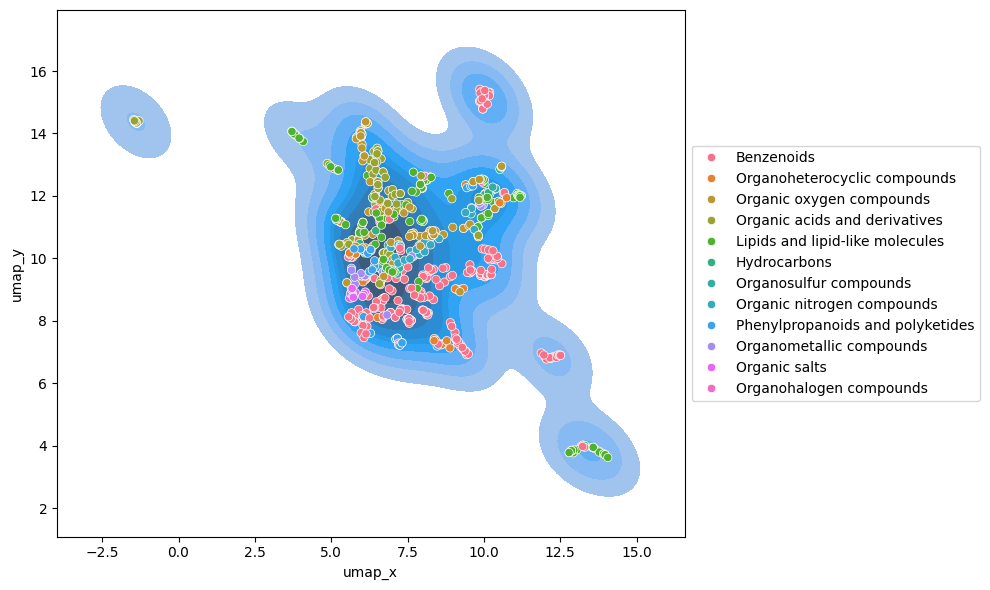

In [112]:
#| label: fig-classyfire
#| fig-cap: "UMAP plot colour coded by ClassyFire superclasses"
fig, ax = plt.subplots(figsize = (10,6))
#color_dict = dict({1: 'red', 0: 'blue'})
sns.kdeplot(x = 'umap_x', y = 'umap_y', fill = True,data = result)
sns.scatterplot(x = 'umap_x', y = 'umap_y' ,   hue = 'superklass', data = result )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(figures_dir/'umap_df.png', dpi = 300)

Analogue Evidence streams


Extracted the first evidence stream from all those noted in the dataset, across the 157 examples - there were 85 evidence streams - of these the majority of initial means of identifying candidate analogues were by structural considerations - in only 4 cases was Metabolism the first consideration

In [113]:
#df1.Index

In [114]:
df1.columns

Index(['Substance Name in Assessment', 'substance_role', 'Approach', 'dtxsid',
       'Preferred Name', 'CASRN', 'SMILES', 'QSAR Ready SMILES',
       'analogue_evidence_stream', 'use_case', 'source'],
      dtype='object')

In [72]:
#df1['analogue_evidence_stream'].unique()

In [79]:
first = [str(e).split('|')[0].strip() for e in df1['analogue_evidence_stream'] ]

In [84]:

first = [x for x in first if x != 'nan']

In [88]:
len(set([e for e in first if 'Structural' in e]))

85

In [89]:
len(set([e for e in first if 'Metab' in e]))

14

In [208]:
len([e for e in list(set([str(e).split('|')[0] .strip() for e in df1['analogue_evidence_stream']]))])

100

In [209]:
structural_tags = [e.replace('Structural_', '')  for e in list(set([str(e).split('|')[0].strip() for e in df1['analogue_evidence_stream']])) if 'Structural_' in e]


In [210]:
structural_tags = [e.strip() for e in structural_tags]

In [212]:
#structural_tags

Creating a simple mapping dict to summarise the types of structural flags/tools/approaches used

In [214]:
structural_tags_dict = {'OECD-Toolbox_diphenylamine-core_dialkylated-substitutions' : 'OECD-Toolbox',
 'C1-C8-alkyl-esters-of-methacrylic-acid' : 'common-functional-groups',
 'acid-dissociation': 'Other',
                         'common-functional-group-formate': 'common-functional-groups',
                        'common-reactive-functional-group': 'common-functional-groups',
                        'common-functional-groups_similar-2D-structure': 'common-functional-groups',
                        'similar-scaffold_common-functional-group': 'common-functional-groups',
             'shared-4-ring-structure_similar-molecular-weight': 'common-functional-groups',           
                'high-molecular-weight-aliphatic-thiols_common-functional-group' : 'common-functional-groups',        
                        'common-functional-group': 'common-functional-groups',
                        'common-reactive-ester-bond_similar-alkyl-side-chains':'common-functional-groups' ,
                        'common-functional-group_short-chain-length': 'common-functional-groups' ,
                   'common-functional-groups_structurally-similar-to-target-hydrolysis-product': 'common-functional-groups',
 'reactive-chlorine-group': 'common-functional-groups',
 'C2-C4-aliphatic-thiols_common-functional-group' :  'common-functional-groups',   
       'common-reactive-moiety_low-molecular-weight': 'common-functional-groups',
 'common-moieties': 'common-functional-groups',
 'common-reactive-functional-group': 'common-functional-groups',
 'common-general-molecular-structure': 'common-functional-groups',
 'chlorosilanes_reactive-chlorine-groups':'common-functional-groups' ,
 'common-polar-constituent-and-olefin-moiety': 'common-functional-groups',
 'common-functional-groups_reactive-chlorine-groups':'common-functional-groups' ,
 'common-functional-group-formate': 'common-functional-groups',                 
   'common-functional-groups_similar-2D-structure': 'common-functional-groups',                     
        'simple-straight-chain-configuration': 'common-functional-groups',
 'silanol_similar-structure-to-target-hydrolysis-product': 'common-functional-groups',                
               'dimethyltin-moiety': 'common-functional-groups' ,
                        'acid-dissociation': 'Other',
                        'similarity': 'Other',
                        'salts-of-same-parent-compound': 'Other',
                        
                        'Tanimoto_isomers': 'Other',
                        'shared-4-ring-structure_similar-molecular-weight': 'common-functional-groups',
 'common-functional-groups_isomers':'common-functional-groups',     
                        'common-functional-group_short-chain-length':'common-functional-groups',
 'repeating-units_common-functional-group' :'common-functional-groups',
                        'repeating-units_common-functional-groups': 'common-functional-groups',
                        'variable-alkyl-chain': 'common-functional-groups',
                        'chlorosilanes_reactive-chlorine-groups': 'common-functional-groups',
                        'common-functional-group' : 'common-functional-groups',
 'salts-of-same-parent-compound': 'Other',
 'dinitrobenzene-isomers' :'common-functional-groups',
 'ChemIDPlus': 'ChemIDPlus',
 'ChemIDplus_OECD Toolbox-Tanimoto_highest-structural-similarity':'OECD-Toolbox-ChemIDPlus',
 'DSSTox_ChemIDPlus':'DSSTox-ChemIDPlus',
 'common-functional-groups' : 'common-functional-groups',
 'SciFinder_ChemID_close-similarity':'Scifinder-ChemIDPlus',
 'ChemIDPlus_Chemical-Class_dinitrophenols':'ChemIDPlus',
 'ChemIDPlus_alkylbenzenes': 'ChemIDPlus',
 'ChemIDPlus_Chemical-Class_brominated-benzenes':'ChemIDPlus',
 'C4-olefin-isomers': 'common-functional-groups',
 'OECD-Toolbox_diphenylamine-core_ variable-number-phenyl-substitutions':'OECD-Toolbox',
 'OECD Toolbox-Tanimoto':'OECD-Toolbox',
     'OECD-QSAR-Toolbox_Tanimoto': 'OECD-Toolbox',                   
 'acid-chlorides_reactive-chlorines':'common-functional-groups',
 'benzene-backbone_mono-substituted-phenols':'common-functional-groups',
 'C6-C14-aliphatic-chain-olefins':'common-functional-groups',
 'SciFinder_ChemID_close-similarity':'Scifinder-ChemIDPlus',
 'OECD-Toolbox_ diphenylamine-core_variable-number-alkyl-substitutions':'OECD-Toolbox',
 'hydrolysis-pair': 'Other',
                        'OECD-Toolbox_ diphenylamine-core_monoalkylated-substitution': 'OECD-Toolbox',
 'RDKit_2-branched-aliphatic-carboxylic-acids_comparable-chain-lengths':'common-functional-groups',
      'OECD-Toolbox_ diphenylamine-core_variable-number-alkyl-substitutions':'OECD-Toolbox',                   
            'OECD-Toolbox_diphenylamine-core_ variable-number-phenyl-substitutions':'OECD-Toolbox',            
                    'ChemIDplus_OECD Toolbox-Tanimoto_highest-structural-similarity':'OECD-Toolbox-ChemIDPlus',    
              
        'DSSTox_ChemIDPlus_similar-branched-structure':'DSSTox-ChemIDPlus',                
           'ChemIDPlus_alkylbenzenes_similar-straight-chain-structure':   'ChemIDPlus',           
             'OECD Toolbox_ChemIDPlus':   'OECD-Toolbox-ChemIDPlus',         
                      'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox_highest-structural-similarity': 'DSSTox-ChemIDPlus-OECD-Toolbox',  
 'OECD-Toolbox_diphenylamine-core':'OECD-Toolbox',
 'ChemIDPlus-OECD Toolbox':'OECD-Toolbox-ChemIDPlus',
 'shared-4-ring-structure_similar-molecular-weight':'common-functional-groups',
 'common-functional-group-peroxy':'common-functional-groups',
 'ChemTunes-ToxGPS_common-alkyl-substituents':'ChemTunes-ToxGPS',
                        'ChemTunes-ToxGPS_Tanimoto_common-functional-groups': 'ChemTunes-ToxGPS',
 'oligomer-mixtures-of-alkyl-phenols-or-phenates':'common-functional-groups',
 'DSSTox_OECD Toolbox-Tanimoto_ChemIDplus_functional-group-aldehyde':'DSSTox-ChemIDPlus-OECD-Toolbox',
                        'DSSTox_OECD Toolbox-Tanimoto_ChemIDplus_functional-group-aldehyde_closest-in-carbon-chain-length' : 'DSSTox-ChemIDPlus-OECD-Toolbox',
 'DSSTox_ChemIDPlus': 'DSSTox-ChemIDPlus',
 'ChemIDPlus':'ChemIDPlus',
                        'CHRIP_OECD-Toolbox_common-phenolic-group-at-same-position-on-benzotriazole': 'OECD-Toolbox',
                         'OECD-Toolbox_ diphenylamine-core_monoalkylated-substitution': 'OECD-Toolbox',
                        'OECD-Toolbox_diphenylamine-core_dialkylated-substitutions': 'OECD-Toolbox',
                        'OECD-Toolbox_ diphenylamine-core_variable-number-alkyl-substitutions':'OECD-Toolbox',
                         'OECD-Toolbox_diphenylamine-core_dialkylated-substitutions':'OECD-Toolbox',
 'OECD-Toolbox_diphenylamine-core': 'OECD-Toolbox',
 'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox_highest-structural-similarity': 'OECD-Toolbox',
                        'OECD Toolbox-Tanimoto': 'OECD-Toolbox',
                        'ChemIDPlus_OECD-Toolbox-Tanimoto': 'OECD-Toolbox-ChemIDPlus',
           'DSSTox_ChemIDPlus_similar-branched-structure': 'DSSTox-ChemIDPlus',   
                        'DSSTox_similar-scaffold-short-chained-alkylbenzenes': 'DSSTox',
                        'ChemIDPlus_Chemical-Class_dinitrophenols': 'ChemIDPlus',
                         'ChemIDPlus_alkylbenzenes': 'ChemIDPlus',
                        'ChemIDplus_OECD Toolbox-Tanimoto_highest-structural-similarity': 'OECD-Toolbox-ChemIDPlus',
                      'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox': 'DSSTox-ChemIDPlus-OECD-Toolbox',
 'OECD-Toolbox_diphenylamine-core_ variable-number-phenyl-substitutions': 'OECD-Toolbox',
 'OECD-QSAR-Toolbox_Tanimoto': 'OECD-Toolbox',
                        'ChemIDPlus_alkylbenzenes_similar-straight-chain-structure': 'ChemIDPlus',
                        'OECD Toolbox_ChemIDPlus': 'OECD-Toolbox-ChemIDPlus',
                        'ChemIDPlus-OECD Toolbox': 'OECD-Toolbox-ChemIDPlus',
                        'RDKit_2-branched-aliphatic-carboxylic-acids_comparable-chain-lengths': 'common-functional-groups',
 'OECD-Toolbox_ diphenylamine-core_monoalkylated-substitution':'OECD-Toolbox',
 'DSSTox_OECD Toolbox-Tanimoto_ChemIDplus_functional-group-aldehyde_closest-in-carbon-chain-length':'DSSTox-ChemIDPlus-OECD-Toolbox',
 'RDKit_aliphatic-carboxylic-acids_same-position-branched-alkyl-side-chains':'common-functional-groups',
 'KNIME_RDKIT_SMARTS_common-toxophore_similar-3D-structure' :'common-functional-groups' ,
 'OECD Toolbox_ChemIDPlus':'OECD-Toolbox-ChemIDPlus',
 'common-reactive-ester-bond_similar-alkyl-side-chains':'common-functional-groups',
 'common-functional-groups_similar-2D-structure':'common-functional-groups',
 'common-functional-group-formate':'common-functional-groups',
 'OECD Toolbox-Tanimoto' : 'OECD-Toolbox',
                        
               'reactive-chlorine-group': 'common-functional-groups',         
                     'variable-alkyl-chain': 'Other',
                        
                          'Tanimoto_common-substructure_close-similarity': 'common-functional-groups', 
 'Tanimoto_common-functional-group_branched-chain-primary-alcohol': 'common-functional-groups', 
 
 'Tanimoto_common-functional-group_structural-isomers': 'common-functional-groups', 
 
 'repeating-units_common-functional-groups': 'common-functional-groups', 
 'high-molecular-weight-aliphatic-thiols_common-functional-group': 'common-functional-groups', 
 'common-polar-constituent-and-olefin-moiety': 'common-functional-groups', 
  'common-reactive-moiety_low-molecular-weight': 'common-functional-groups', 
 'Tanimoto_common-cyclic-structure': 'common-functional-groups', 
 'C6-C14-aliphatic-chain-olefins': 'common-functional-groups', 
 
 'repeating-units_common-functional-group': 'common-functional-groups', 
 'Tanimoto_common-functional-group': 'common-functional-groups', 
 
 'C4-olefin-isomers': 'common-functional-groups', 
 
 'common-reactive-ester-bond_similar-alkyl-side-chains': 'common-functional-groups', 
 'common-functional-groups_isomers': 'common-functional-groups', 

 'Tanimoto_common-functional-group_close-similarity': 'common-functional-groups', 
 'RDKit_aliphatic-carboxylic-acids_same-position-branched-alkyl-side-chains': 'common-functional-groups', 
 'silanol_similar-structure-to-target-hydrolysis-product': 'common-functional-groups', 
 
 'oligomer-mixtures-of-alkyl-phenols-or-phenates': 'common-functional-groups', 
 'C1-C8-alkyl-esters-of-methacrylic-acid': 'common-functional-groups', 
 
 'common-functional-groups_reactive-chlorine-groups': 'common-functional-groups', 
 'common-functional-group-peroxy': 'common-functional-groups', 
 'simple-straight-chain-configuration': 'common-functional-groups', 
 'Tanimoto_stereoisomer': 'common-functional-groups', 
 'KNIME_RDKIT_SMARTS_common-toxophore_similar-3D-structure': 'common-functional-groups', 
 'common-general-molecular-structure': 'common-functional-groups', 
 'C2-C4-aliphatic-thiols_common-functional-group': 'common-functional-groups', 
 'acid-chlorides_reactive-chlorines': 'common-functional-groups', 
 'Tanimoto_common-functional-group_common-structural-fragment': 'common-functional-groups', 
 'Tanimoto_common-functional-groups': 'common-functional-groups', 
 'common-moieties': 'common-functional-groups',         
 'dibutyltin-moiety':'common-functional-groups',
 'DSSTox_ChemIDPlus_similar-branched-structure': 'DSSTox-ChemIDPlus',
 'variable-alkyl-chain':'common-functional-groups',
 'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox' : 'DSSTox-ChemIDPlus-OECD-Toolbox',
 'Open-Babel-toolbox-Tanimoto_common-functional-groups': 'Open-Babel',
 'common-functional-group':'common-functional-groups',
 'common-functional-groups':'common-functional-groups',
 'simple-straight-chain-configuration':'common-functional-groups',
 'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox_highest-structural-similarity':'DSSTox-ChemIDPlus-OECD-Toolbox',
 'Leadscope_ChemID_expert_judgement': 'Leadscope-ChemIDPlus',
 'ChemIDPlus_alkylbenzenes_similar-straight-chain-structure': 'ChemIDPlus',
 'CHRIP_OECD-Toolbox_common-phenolic-group-at-same-position-on-benzotriazole':'OECD-Toolbox' ,
 'OECD-QSAR-Toolbox_Tanimoto':'OECD-Toolbox',
 'chlorosilanes_reactive-chlorine-groups':'common-functional-groups',
 'ChemIDPlus_OECD-Toolbox-Tanimoto':'OECD-Toolbox-ChemIDPlus',
 'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox':'DSSTox-ChemIDPlus-OECD-Toolbox',
 'CHRIP_visual-judgement_single-allyl-alcohol-group': 'Other',
     'CHRIP_visual-judgement_single-allyl-alcohol-group': 'Other',                   
 'common-polar-constituent-and-olefin-moiety':'common-functional-groups',
 'DSSTox':  'DSSTox',
                        'ChemTunes-ToxGPS_common-alkyl-substituents': 'ChemTunes-ToxGPS',   
                       
 'ChemTunes-ToxGPS_Tanimoto_common-functional-groups': 'ChemTunes-ToxGPS',
 'MACCS-TANIMOTO_common-substituents': 'Other',
 'ChemMine-tools_MCS-Tanimoto': 'ChemMine'}

In [215]:
mylst = []
for k,v in structural_tags_dict.items():
    mylst.append(v)

In [216]:
len(set(mylst))

13

In [217]:
structural_tags_df = pd.DataFrame(list(structural_tags_dict.items()), columns = ['Struct-AE', 'Level1-Struct-AE'])

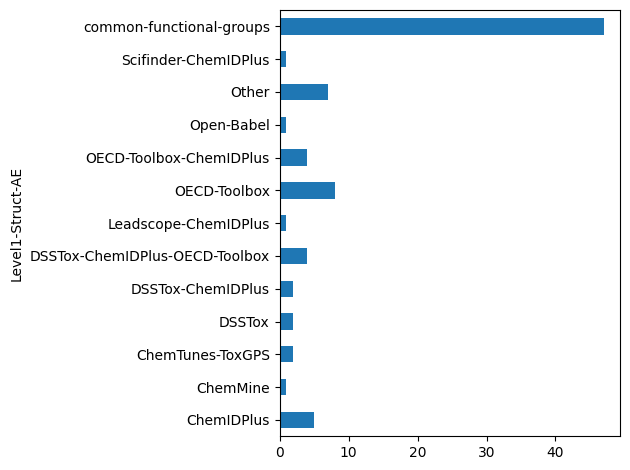

In [219]:
structural_tags_df.groupby('Level1-Struct-AE').size().plot.barh()
plt.tight_layout()
plt.savefig(figures_dir/'analogue_stream.png', dpi = 300)

## Structural similarity within the read-across cases

In [223]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

In [224]:
def distance_matrix(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D_mgrn = pd.DataFrame(squareform(pdist(df, 'jaccard')), columns = df.index, index = df.index)

    return D_mgrn

In [238]:
mydict2 = {}
for i, group in df1.groupby('Index'):
    subset = group[['dtxsid', 'Index', 'SMILES']]
    mydict2[i] = subset.shape[0]

In [246]:
sorted(mydict2.values(), reverse =True)[:10]

[42, 24, 20, 19, 17, 16, 15, 15, 14, 12]

In [252]:
np.mean((list(mydict2.values())))

5.076433121019108

In [225]:
mydict = {}
for i, group in df1.groupby('Index'):
    subset = group[['dtxsid', 'Index', 'SMILES']]
    try:
        a = mk_fp(subset)
        b = distance_matrix(a)
        b1 = 1 - b
        mk = np.triu(np.ones(b1.shape), k=0)
        b2 = b1.where(mk==1, np.nan).unstack().reset_index().dropna()
        b2 = b2[b2['level_0'] != b2['level_1']]
        b2 = b2.iloc[:,2].values
        mydict[i] = b2
    except Exception as error:
        print(i, error)


40 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
41 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
47 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
50 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
54 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
55 No registered converter was able to produce a C++ rvalue of type st

In [78]:
#mydict


In [226]:
new_df = pd.DataFrame({k:v for k,v in mydict.items() if len(v) >1}.items())
new_df['meds'] = [np.median(e) for e in new_df[1]]
new_df = new_df.sort_values(by = 'meds', ascending = False)

In [227]:
new_df['meds'].median()

0.34252017608217167

In [228]:
#new_df

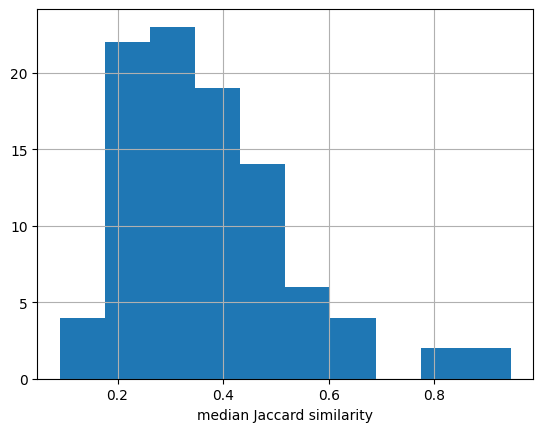

In [229]:
new_df['meds'].hist()
plt.xlabel('median Jaccard similarity')
plt.savefig(figures_dir/'median_JS_dist.png', dpi = 300)

In [75]:
labels, data = list(zip((new_df[0].values, new_df[1].values)))


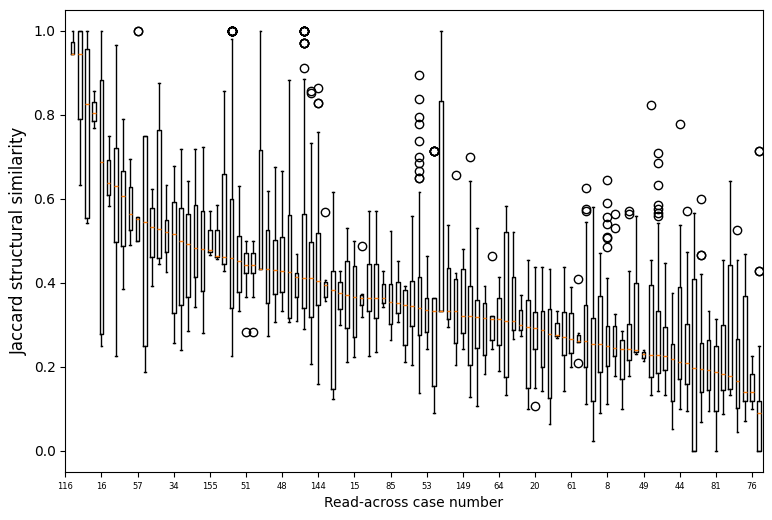

In [234]:
fig, ax = plt.subplots(figsize = (9,6))
labels, data = list(zip((new_df[0].values, new_df[1].values)))
ax.boxplot(data[0], vert=True)  # Set vert=True to flip the axis

n = 5  # Change this to set the interval of tick labels
selected_indices = range(0, len(labels[0]), n)
selected_labels = [labels[0][i] for i in selected_indices]

# Set the selected tick positions and labels
plt.xticks(selected_indices, selected_labels, fontsize=6)
plt.xlabel('Read-across case number')
plt.ylabel('Jaccard structural similarity', fontsize = 12)
fig.savefig(figures_dir/'Jaccard_SS.png', dpi = 300)

In [229]:
#mydict